# Sunspot Data

https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019?resource=download&select=sunspot_data.csv

https://datatofish.com/import-csv-file-python-using-pandas/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv (r'Data/SN_d_tot_V2.0.csv', delimiter=';')
df.head()

,Year,Month,Day,Date in Fraction of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [3]:
xcol = 'Date in Fraction of Year'
ycol = 'Number of Sunspots'

## SVG Smoothing

The data we have is very noisy. In order to paint a picture as to what is going on one thing we might want to do is **smooth** the data. We do this using a ***Savitzky-Golay Filter*** (SVG). This works by fitting a sub-set of adjacent data points with a low-degree polynomial by the method of linear least squares. When the data points are equally spaced, an analytical solution to the least-squares equations can be found  in the form of a single set of "convolution coefficients" that can be applied to all data sub-sets, to give estimates of the smoothed signal. https://en.wikipedia.org/wiki/Savitzky–Golay_filter

For a data set with points $\{x_j, y_j\}, j = 1, \dots, n$, with $m$ convolution coefficients given by $C_i$. Our smoothed signal $Y_j$ is given by:

$$Y_j = \sum_{i = \frac{1-m}{2}}^{\frac{m-1}{2}} C_i y_{i+j}$$ 

$\frac{m+1}{2} \leq j \leq n - \frac{m-1}{2} $

Fortunately, the Scipy module has a module which calculates the SVG for us. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [4]:
from scipy.signal import savgol_filter

In [5]:
window_length = int((4 * 365)+1) # the number of coefficients --> must be odd
poly_order = [1, 2] # order of the polynomial used to fit the samples
smoothed = [savgol_filter(df[ycol].values, window_length, poly_order[i]) for i in range(2)]

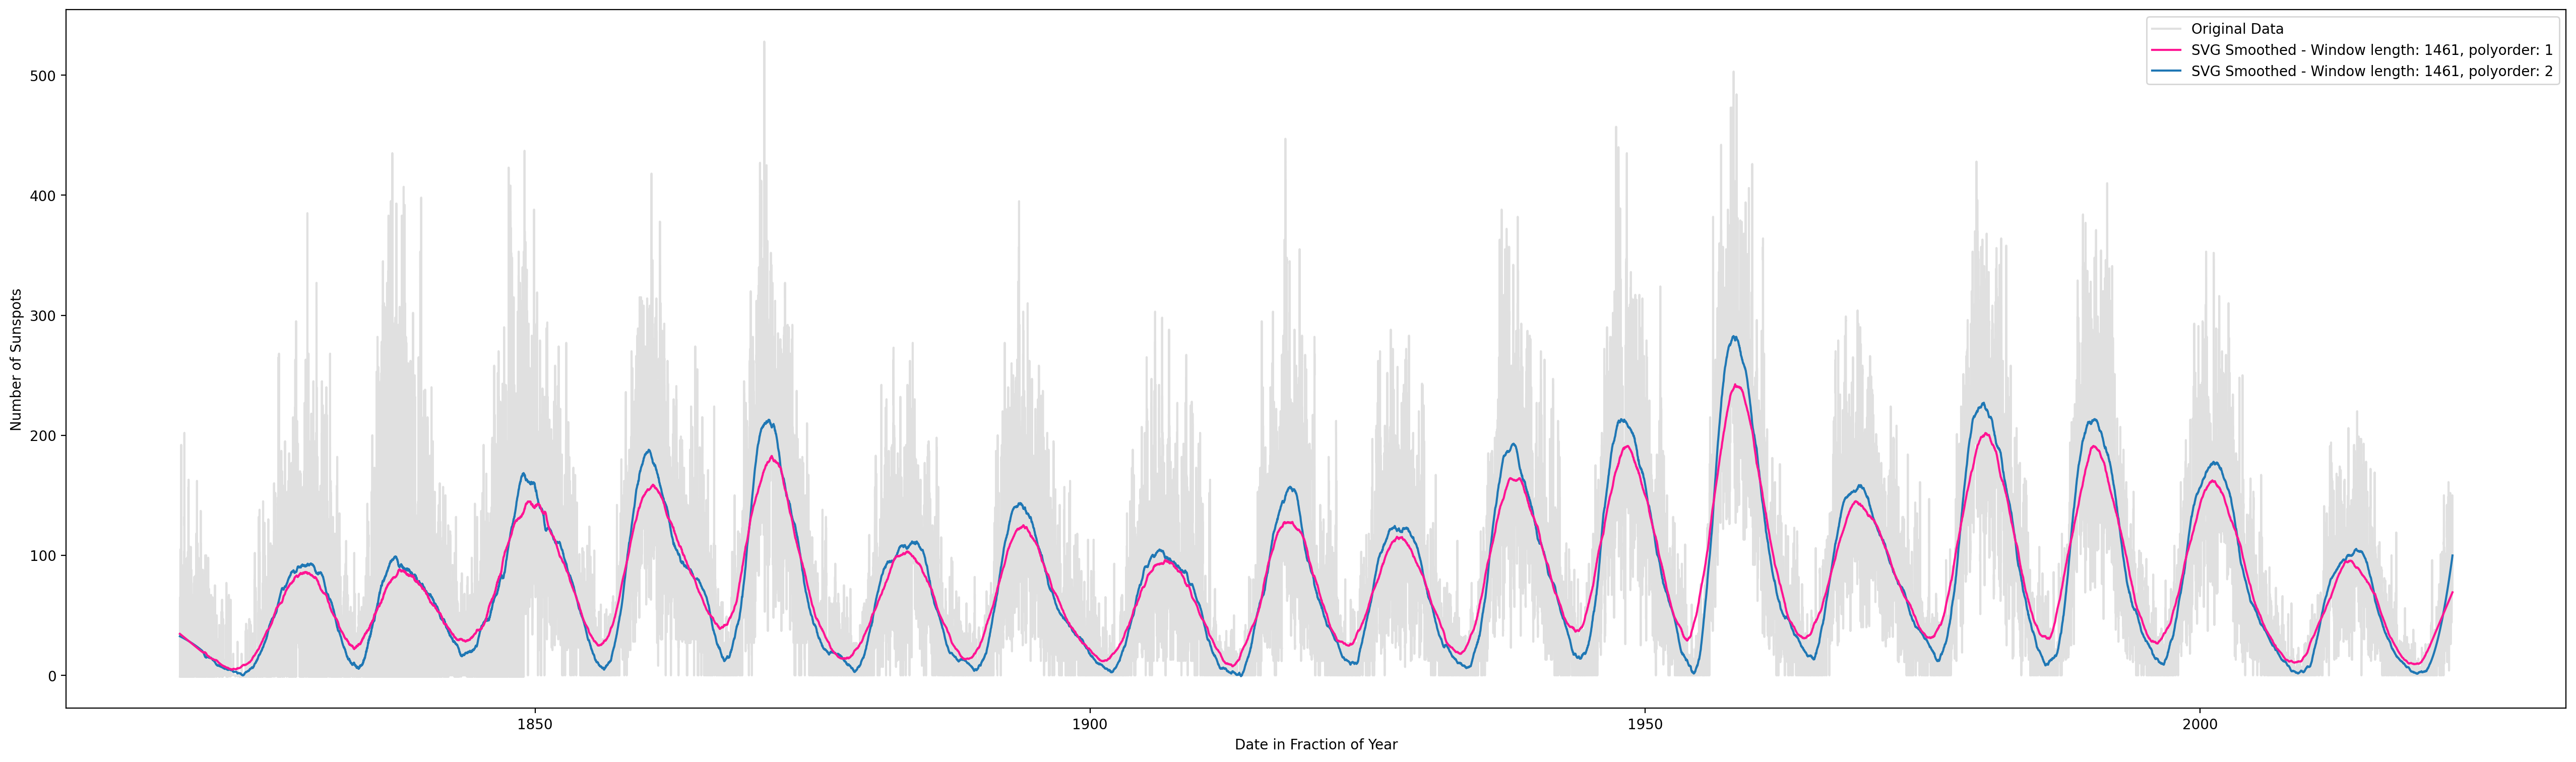

In [6]:
alpha=0.7
zorder = [99, 98]
color = ['deeppink', 'tab:blue','lightgrey']

fig, ax = plt.subplots(dpi=200, figsize=[32, 9])
ax.plot(df[xcol], df[ycol], alpha=alpha, label='Original Data', color=color[2])
for i in range(2):
    ax.plot(df[xcol], smoothed[i],
        label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[i]}', 
       zorder=zorder[i], color = color[i])
ax.set_xlabel(xcol)
ax.set_ylabel(ycol)
ax.legend();

#### Comment on plot:

The plot above shows the noisy data in blue, as well as two different SVG smoothed signals, both with the same window length, but different polyorders. The two signals show the extent of how noisy the data is. We can see that for each cycle the smoothed amplitude is much lower than the maximum suggested by the data.

The orange line (polyorder = 1) shows a smoother fit, containing fewer turning points than the green line. We can use this line to find the turning points, and from there determine the amplitude of the peaks so that we can see if there is a pattern to the cycle amplitude.

## Phase Diagram

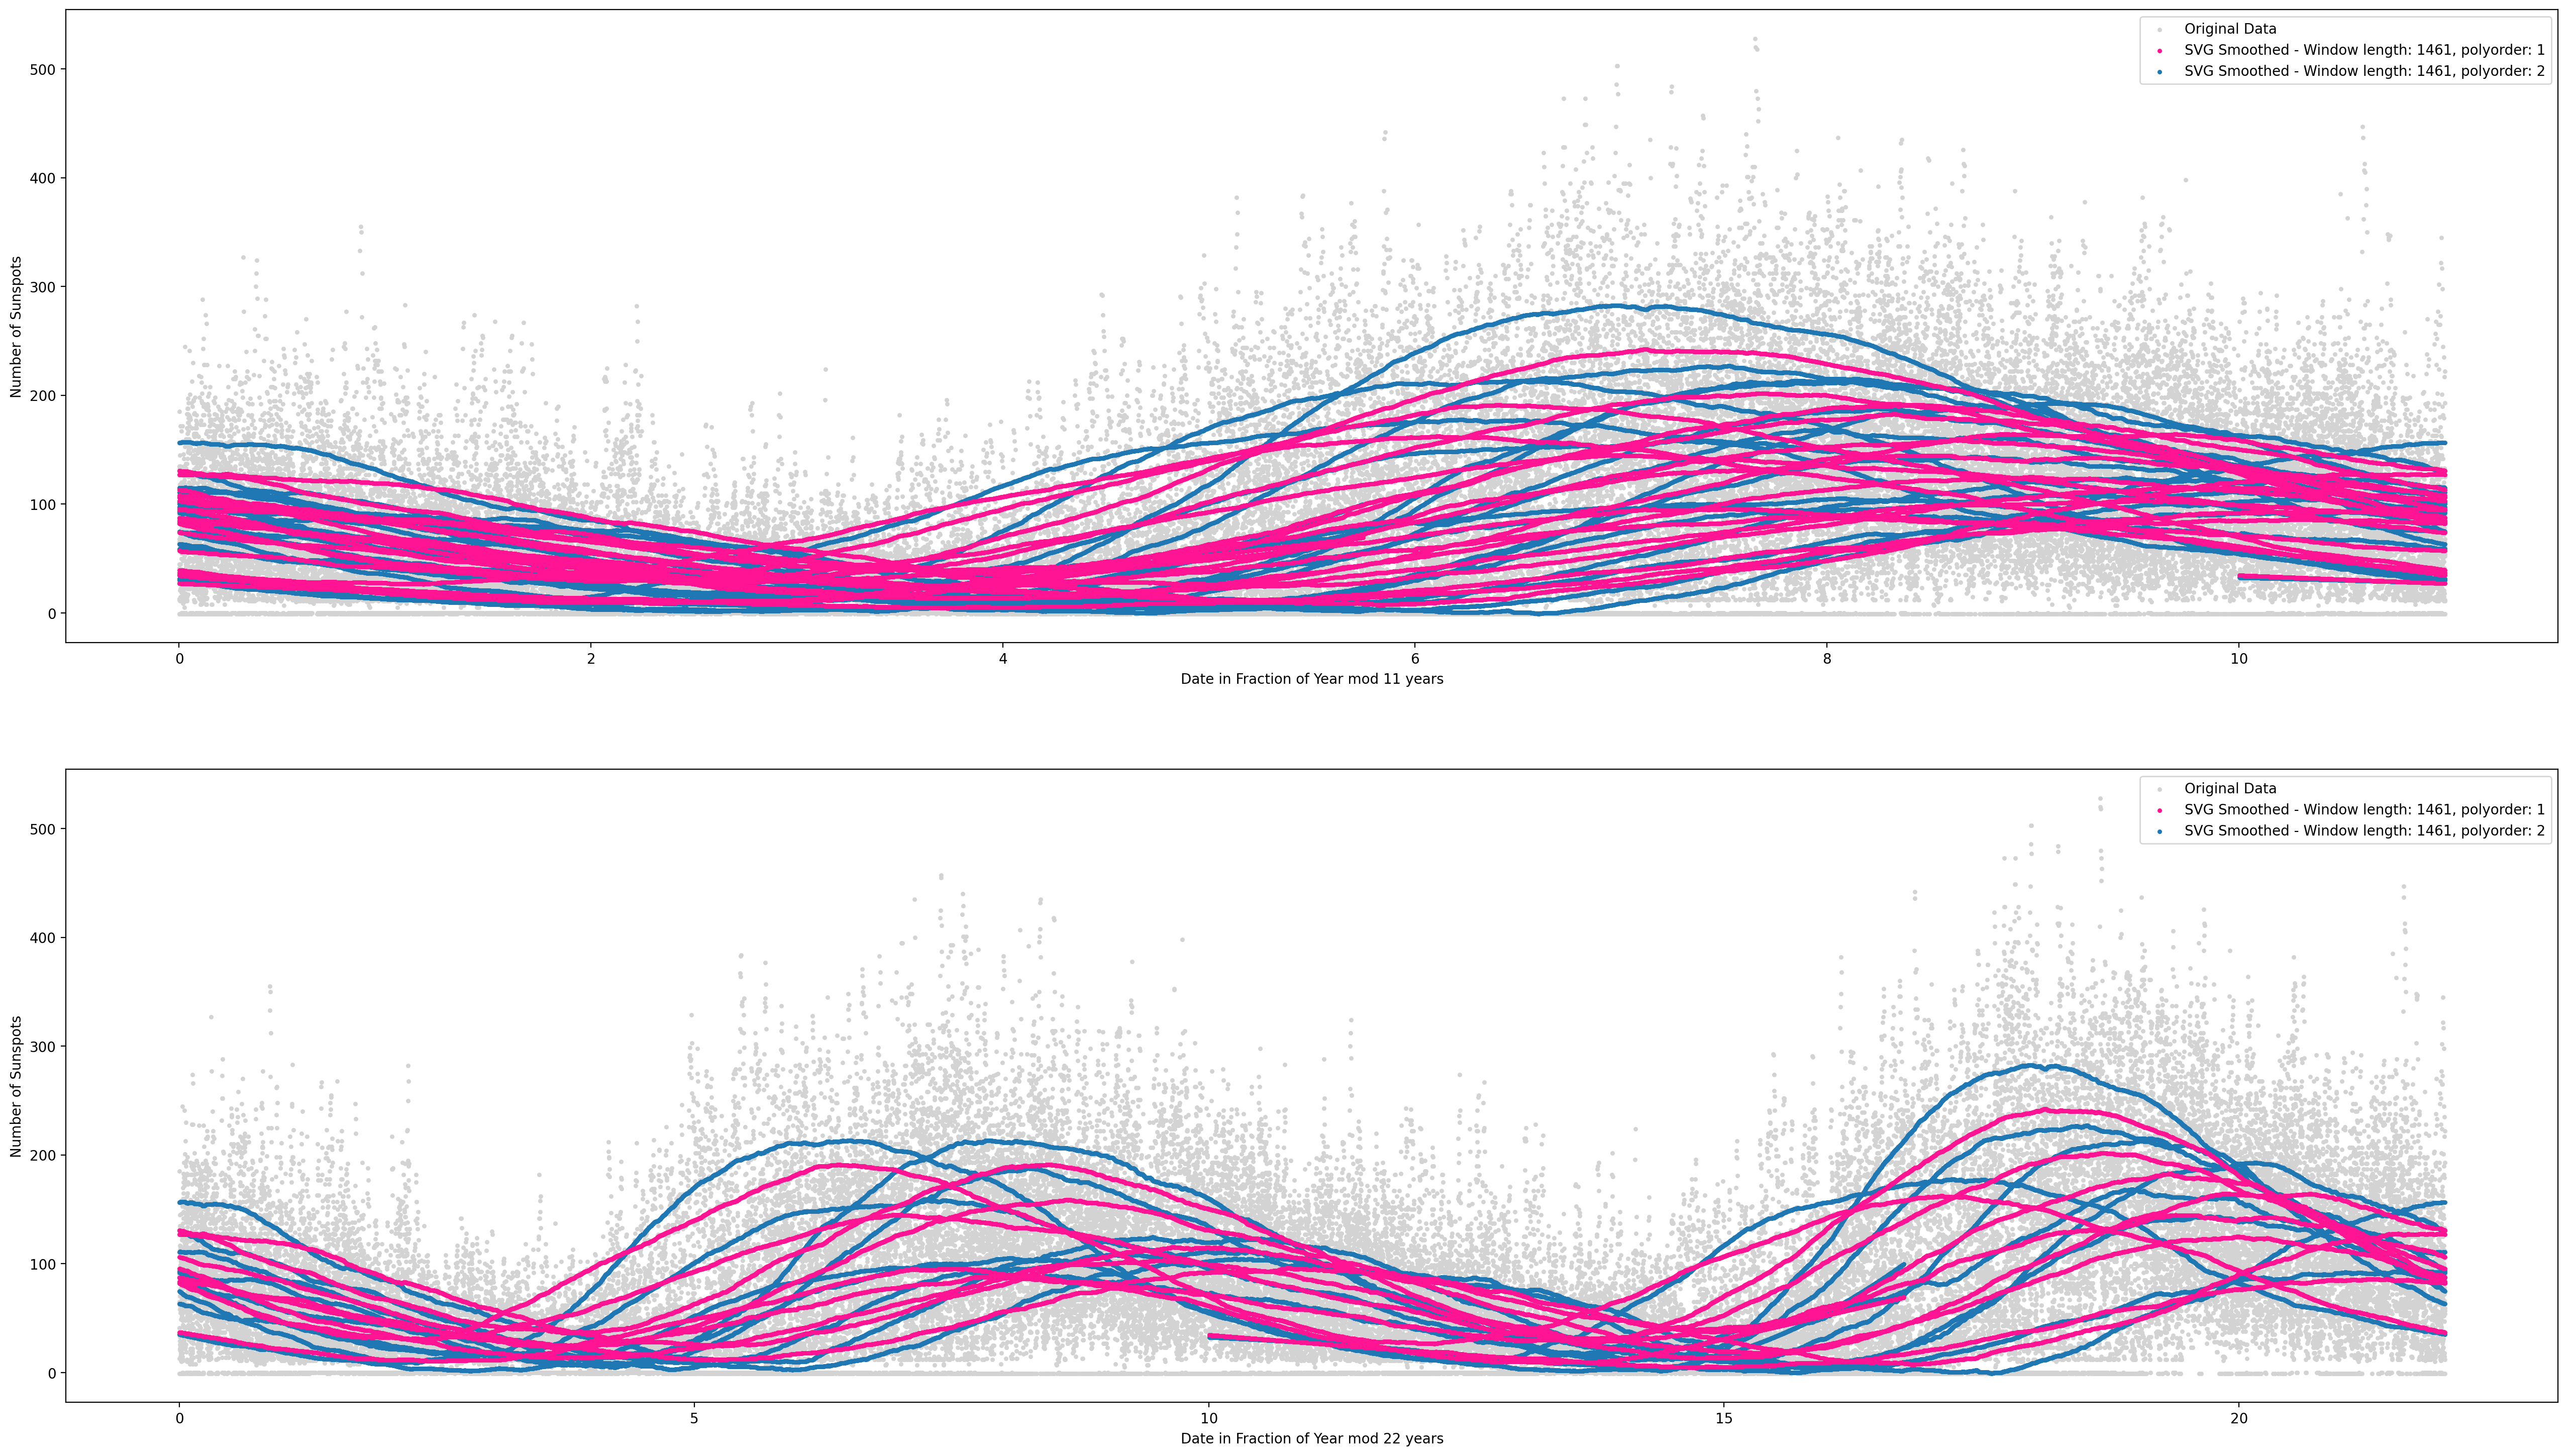

In [7]:
''' Plotting a Phase Diagram '''

time = df[xcol].values - 4
period = [11,22]
phase = [time % (period[i]) for i in range(2)]
s=5

fig, ax = plt.subplots(2, dpi=200, figsize=[32, 18])
for i in range(2):
    ax[i].scatter(phase[i], df[ycol], label='Original Data', color=color[2],s=s)
    ax[i].scatter(phase[i], smoothed[0], 
        label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[0]}',
                  zorder=zorder[0], color=color[0], s=s)
    ax[i].scatter(phase[i], smoothed[1], 
        label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[1]}',
                 zorder=zorder[1], color=color[1], s=s)
    ax[i].set_xlabel(xcol + f' mod {period[i]} years')
    ax[i].set_ylabel(ycol)
    ax[i].legend();

#### Comment on plot:

The plots above show a phase diagram of how each solar cycle's length compares to our estimate of 11 years. The code works by finding the remainder when time is divided by our estimate. If all the cycles had the exact same period (11 years) then the graph would look like the sine curve plotted below, where all the amplitudes would line up at exactly the right spot.

To show the extent of how out of phase the cycles are, I have also plotted a graph of 22 years, which should in theory also look exactly like the sine curve, but instead we see that the phase shift is only amplified.

From this graph we can conclude that the solar cycles do not all have a period of 11 years. For future work we could try and find minimise the phase difference to find which period most accurately describes the average solar cycle.

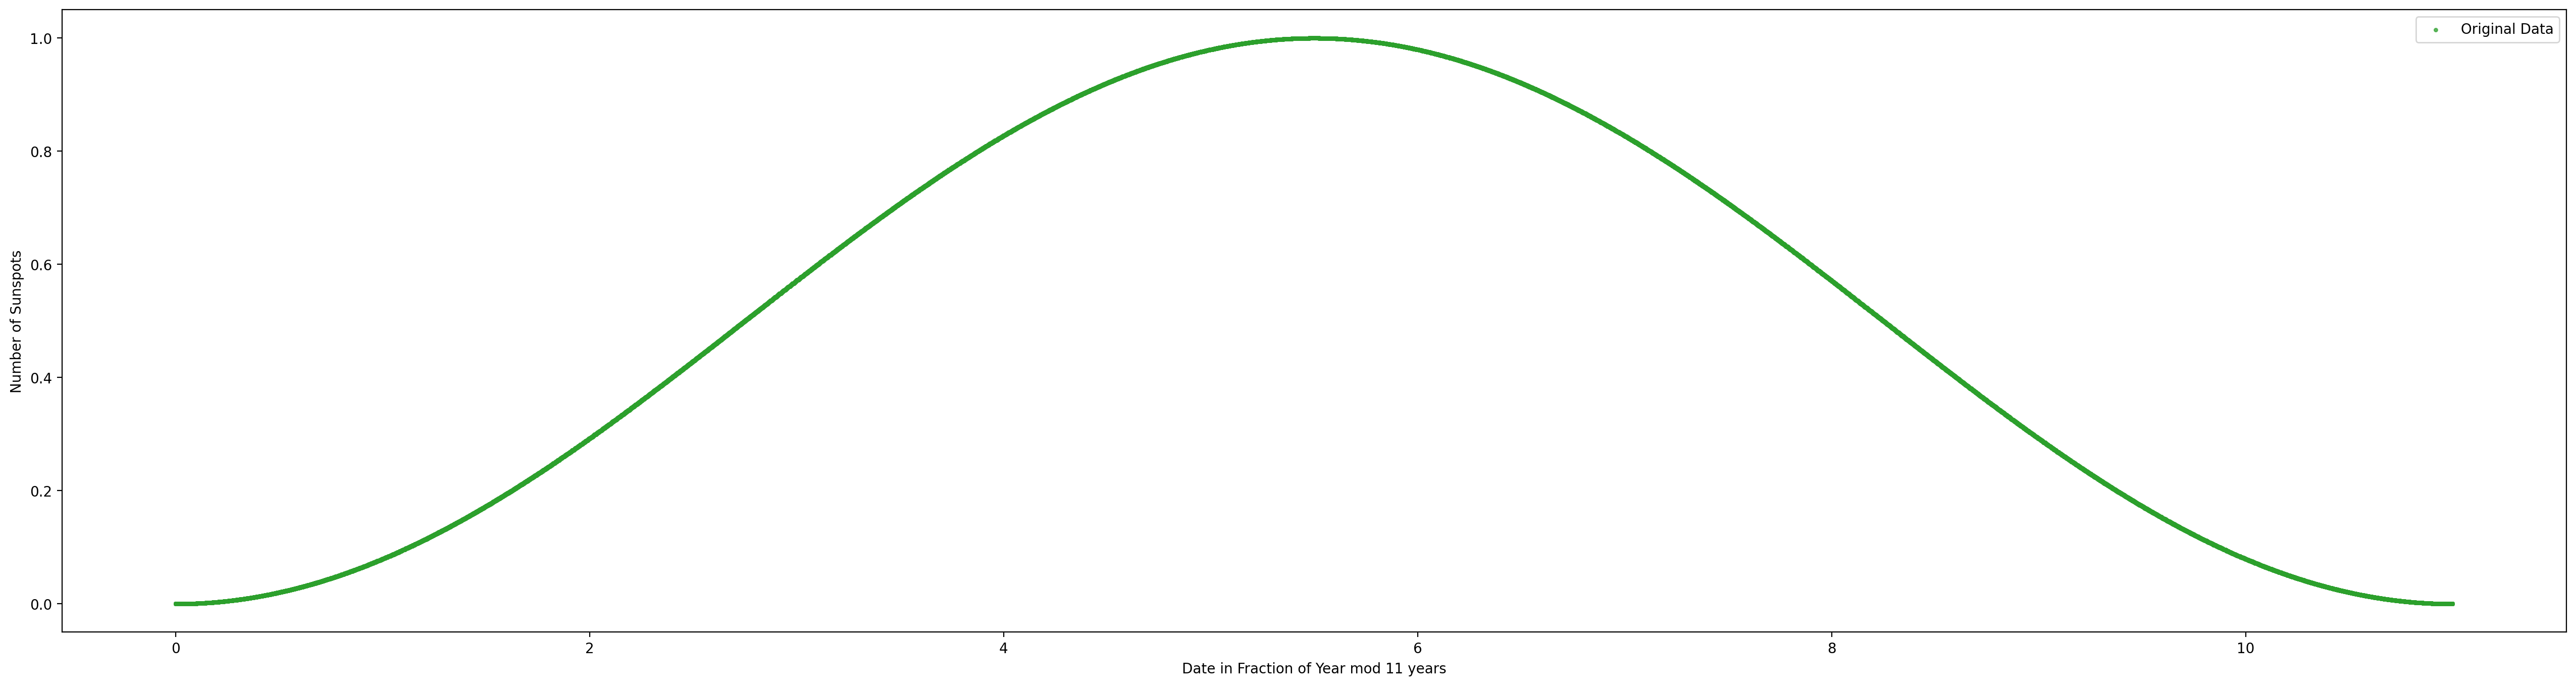

In [8]:
time = df[xcol].values - 4
period = 11
phase = time % (period)
y = np.sin(np.pi / period * time)**2

fig, ax = plt.subplots(dpi=200, figsize=[32, 8])
ax.scatter(phase, y, alpha=alpha, label='Original Data',color='tab:green',s=s)

ax.set_xlabel(xcol + f' mod {period} years')
ax.set_ylabel(ycol)
ax.legend();

## Finding the Peaks

The method used to find the peaks of the SVG signal is to find the positions of the turning points (in years) and then find the amplitude it corresponds to. Scipy has a built in peak-finder, which can find the peaks for us. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [9]:
from scipy.signal import find_peaks

In [10]:
peaks = [find_peaks(smoothed[i], height=75, distance=1800) for i in range(2)]
dates = [df[xcol][peaks[i][0]] for i in range(2)]

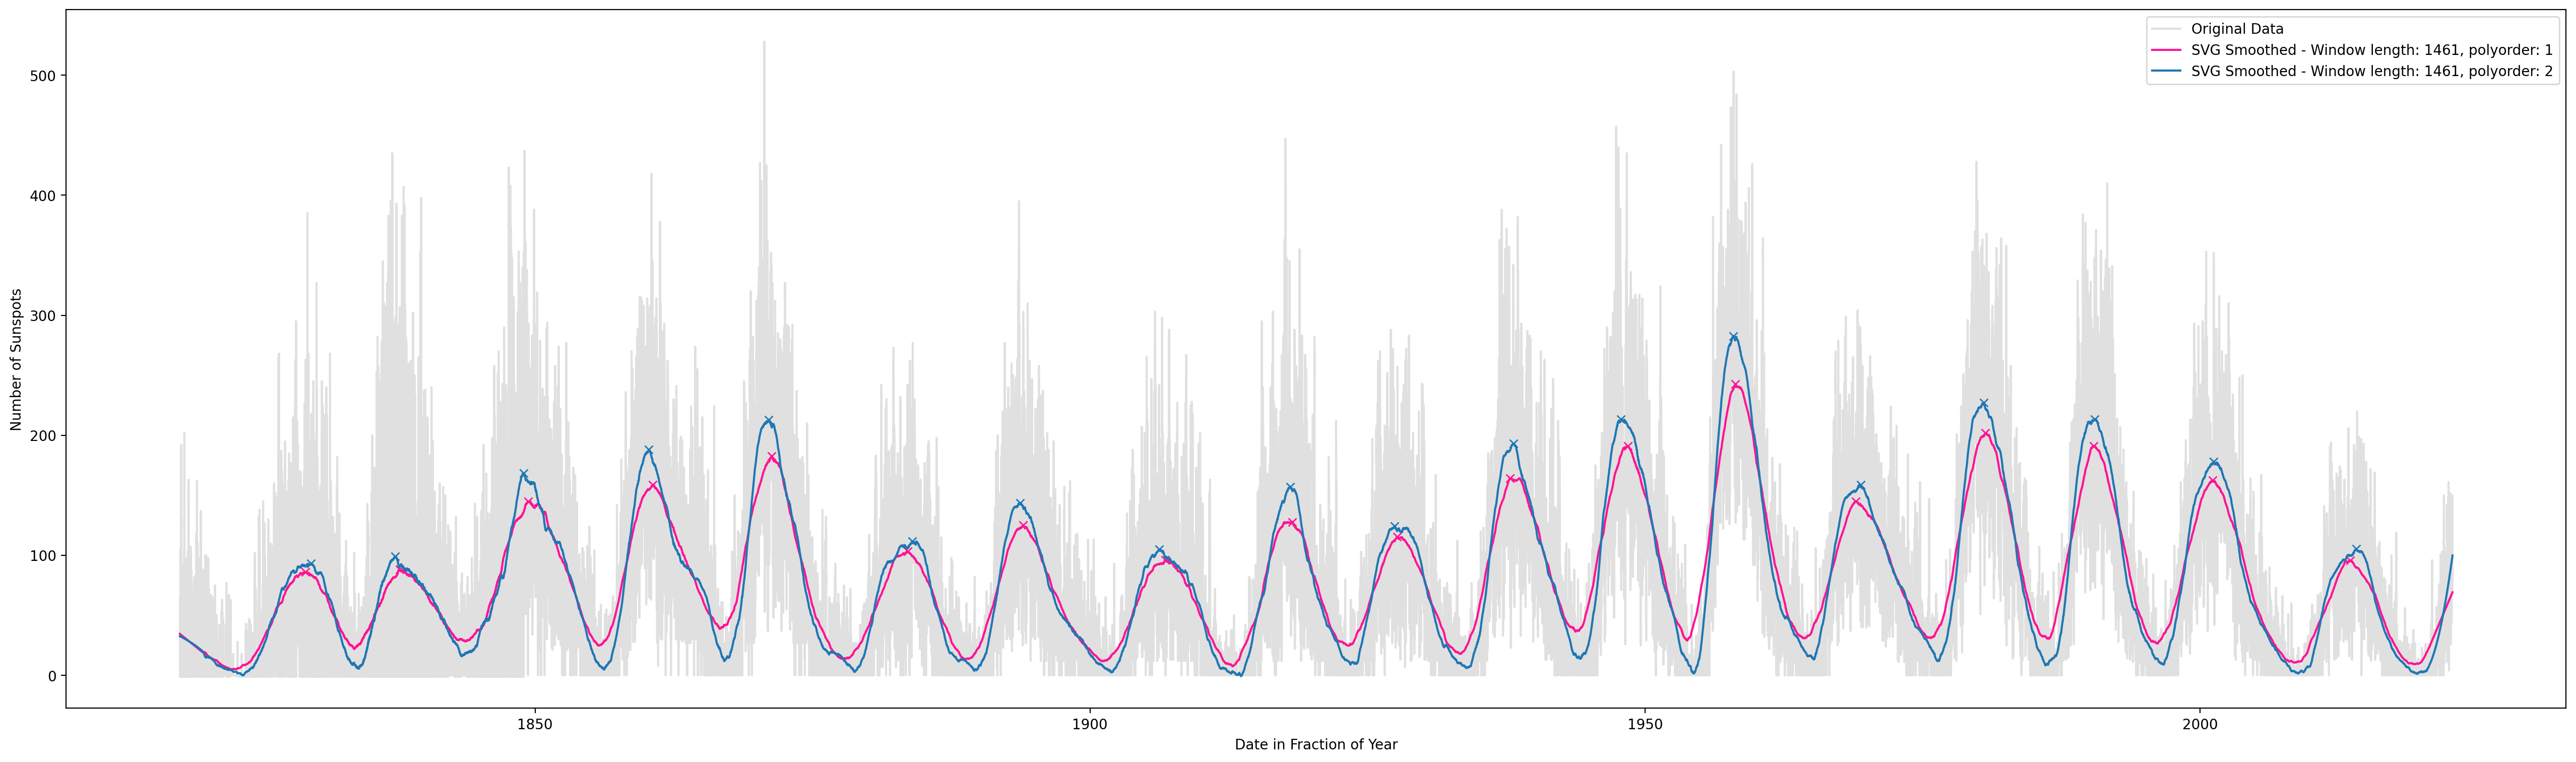

In [14]:
fig, ax = plt.subplots(dpi=200, figsize=[32, 9])
ax.plot(df[xcol], df[ycol], alpha=alpha, label='Original Data', color=color[2]) # original data
for i in range(2):
    ax.plot(df[xcol], smoothed[i],
        label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[i]}', # SVG smoothed signals
       zorder=99, color=color[i])
    ax.plot(dates[i], smoothed[i][peaks[i][0]], 'x', color=color[i]) # positions of peaks   
ax.set_xlabel(xcol)
ax.set_ylabel(ycol)
ax.legend();

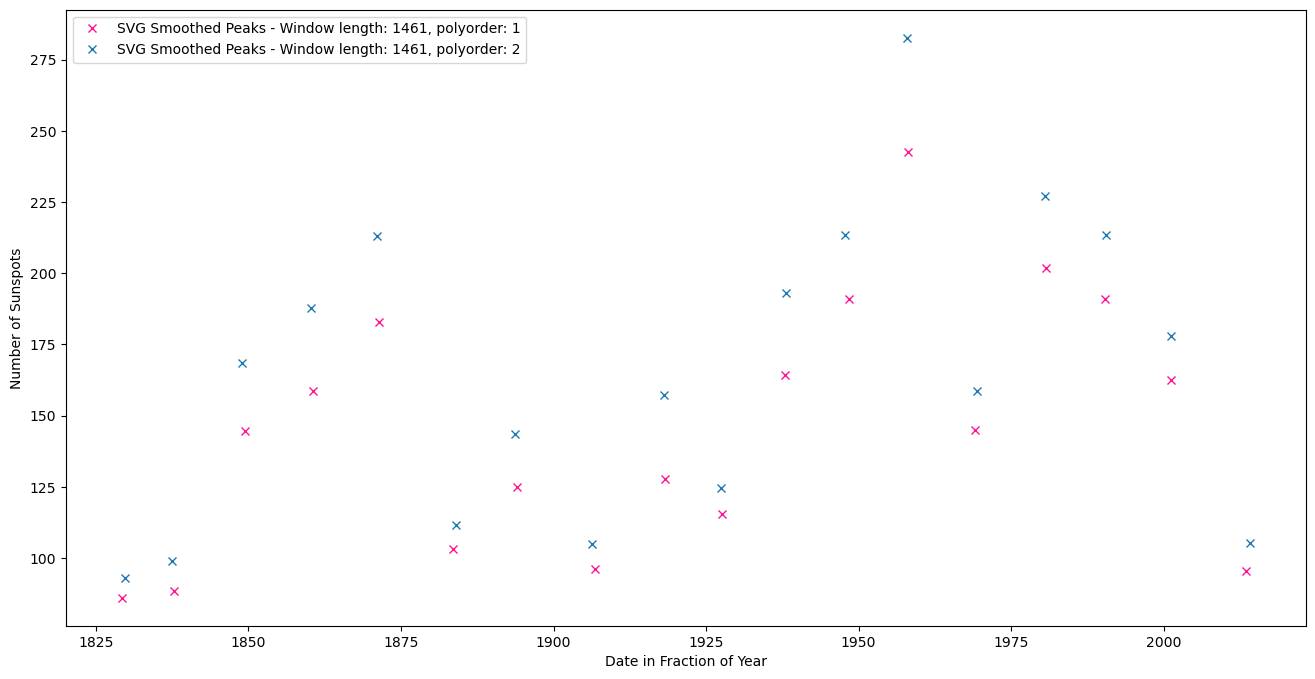

In [13]:
fig, ax = plt.subplots(dpi=100, figsize=[16, 8])
for i in range(2):
    ax.plot(dates[i], smoothed[i][peaks[i][0]], 'x', color=color[i],
           label=f'SVG Smoothed Peaks - Window length: {window_length}, polyorder: {poly_order[i]}') 
ax.set_xlabel(xcol)
ax.set_ylabel(ycol)
ax.legend();

#### Comment on plot:
As we can see from the plot above, there appears to be no distinct pattern to the amplitudes of each peak. As the project progresses, I may be able to create a model which will predict future amplitudes, and use that model to predict the wider solar activity cycle shape.